## Comparing the Krisciunas & Schafer and Parker sky models to DECam sky data

In [1]:
import numpy as np 
import scipy as sp 
# -- astropy -- 
import astropy.time
import astropy.coordinates
import astropy.units as u 
import astropy.time as Time
from astropy.io import fits
from astropy import table as aTable
# -- feasibgs --
from feasibgs import util as UT
from feasibgs import skymodel as Sky
# -- others -- 
import speclite
import specsim.simulator
from astroplan import Observer

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

First lets read in the DECam data and calculate all relevant meta data

In [3]:
fdecam = fits.open(''.join([UT.dat_dir(), 'decalsobs-zpt-dr3-allv2.fits']))
decam = fdecam[1].data

decam = astropy.table.Table()
for name in ('DATE', 'AIRMASS', 'RA', 'DEC', 'FILTER', 'SKYBR', 'MOONSEP', 'MOONPHASE', 'MOONUP', 'SUNALT', 
             'SUNSEP', 'TRANSP', 'EXPTIME', 'ZD', 'SEEING', 'SKYSIG', 'DEPTH'):
    values = fdecam[1].data[name].reshape(-1)
    decam[name] = astropy.table.Column(values)
decam['MOONFRAC'] = decam['MOONPHASE']
decam['MOONPHASE'] = np.arccos(2 * decam['MOONFRAC'] - 1.) / np.pi

In [4]:
time = astropy.time.Time(decam['DATE'], format='jd')
location = astropy.coordinates.EarthLocation.from_geodetic(
    lat='-30d10m10.78s', lon='-70d48m23.49s', height=2241.4*u.m)

moon_position = astropy.coordinates.get_moon(time, location)
moon_ra = moon_position.ra.value
moon_dec = moon_position.dec.value
moon_position_altaz = moon_position.transform_to(astropy.coordinates.AltAz(obstime=time, location=location))
moon_alt = moon_position_altaz.alt.value
moon_az = moon_position_altaz.az.value

def separation(ra1, dec1, ra2, dec2):
    pi2 = np.radians(90)
    alpha = np.cos(np.radians(ra1)-np.radians(ra2))
    first = np.cos(pi2-np.radians(dec1))*np.cos(pi2-np.radians(dec2))
    second = np.sin(pi2-np.radians(dec1))*np.sin(pi2-np.radians(dec2))*alpha
    return np.arccos(first+second)*180/np.pi

separation_angle = separation(decam['RA'], decam['DEC'], ra2=moon_ra, dec2=moon_dec)

decam['MOON_RA'] = moon_ra
decam['MOON_DEC'] = moon_dec
decam['MOON_ALT'] = moon_alt
decam['MOON_AZ'] = moon_az
decam['MOON_SEP'] = separation_angle

In [5]:
coord = astropy.coordinates.SkyCoord(decam['RA'] * u.deg, decam['DEC'] * u.deg)
decam['GAL_LAT'] = coord.galactic.l.deg
decam['GAL_LONG'] = coord.galactic.b.deg
decam['ECL_LAT'] = coord.barycentrictrueecliptic.lat.deg

In [6]:
decam['MONTH_FRAC'] = np.array([(t.month + t.day/30.) for t in time.datetime])

In [7]:
keep = (decam['AIRMASS'] != 0.0)
print("%i of %i have airmass != 0." % (np.sum(keep), len(decam['AIRMASS'])))
transp = (decam['TRANSP'] > .75) & (decam['TRANSP'] < 1.3)
print("%i of %i have transp within 0.75 and 1.3" % (np.sum(transp), len(decam['AIRMASS'])))
#decam = decam[keep]

26561 of 27491 have airmass != 0.
24981 of 27491 have transp within 0.75 and 1.3


In [8]:
boss_blue = aTable.Table.read(''.join([UT.dat_dir(), 'sky/', 'Bright_BOSS_Sky_blue.fits']))

In [9]:
boss_blue.columns

<TableColumns names=('PLATE','IMG','OBJTYPE','MJD','TAI-BEG','TAI-END','RA','DEC','CAMERAS','AIRMASS','ALT','AZ','EXPTIME','SEEING20','SEEING50','SEEING80','RMSOFF20','RMSOFF50','RMSOFF80','DATE-OBS','REDDEN01','REDDEN02','REDDEN03','REDDEN04','REDDEN05','QUALITY','DUSTC','DUSTD','AIRTEMP','DEWPOINT','DUSTA','DUSTB','GUSTD','GUSTS','HUMIDITY','PRESSURE','WINDD','WINDS','OBS_ZENITH','ECL_LAT','ECL_LON','GAL_LAT','GAL_LON','ZODI','ISL','MOOND','MOON_SEP','MOON_ALT','MOON_AZ','MOON_ZENITH','MOON_ILL','MOON_PHASE','SUN_SEP','SUN_ALT','SUN_AZ','SUN_MOON_SEP','MONTH','SUN_SET','SUN_RISE','HOUR','PHOTO','SOLARFLUX','cont_b_615','NaID1','cont_b_380','cont_b_602','cont_b_565','cont_b_510','HgIc','cont_b_583','cont_b_460','NaID2','OI','NaIc','cont_b_480','HgIa','cont_b_425','cont_b_540','HgIb','cont_b_410','NaIb','NI','NaIa','cont_b_642','cont_b_740','cont_b_675','O2a','cont_b_1025','O2b','cont_b_920','cont_b_825','cont_b_710','cont_b_977','cont_b_873','OIr1','cont_b_720','OIr2','cont_b_833','sd

In [10]:
keep_columns = ['AIRMASS', 'MOON_SEP', 'MOON_ALT', 'MOON_ILL', 'SUN_SEP', 'SUN_ALT'] # 'ECL_LON', 'GAL_LAT', 'GAL_LON', 
boss_meta = []
for col in keep_columns: 
    boss_meta.append(np.array(boss_blue[col]))
boss_meta = np.array(boss_meta)

In [11]:
boss_hull = sp.spatial.ConvexHull(boss_meta.T)

In [12]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull, Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

In [13]:
decam_meta = [] 
for col in ['AIRMASS', 'MOON_SEP', 'MOON_ALT', 'MOONFRAC', 'SUNSEP', 'SUNALT']: 
    decam_meta.append(np.array(decam[col]))
decam_meta = np.array(decam_meta)

In [14]:
in_boss_hull = in_hull(decam_meta.T, boss_meta.T)

In [15]:
print('%i DECam data points are within the convex hull of the BOSS meta data' % np.sum(in_boss_hull))

397 DECam data points are within the convex hull of the BOSS meta data


(0.0, 1.0)

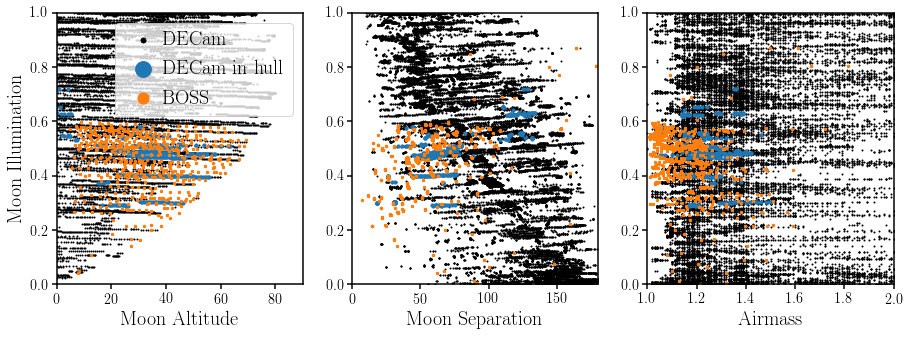

In [36]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(decam['MOON_ALT'][transp & keep], decam['MOONFRAC'][transp & keep], c='k', s=1, label='DECam')
sub.scatter(decam['MOON_ALT'][in_boss_hull], decam['MOONFRAC'][in_boss_hull], c='C0', s=10, label='DECam in hull')
sub.scatter(boss_blue['MOON_ALT'], boss_blue['MOON_ILL'], c='C1', s=5, label='BOSS')
sub.legend(loc='upper right', markerscale=5, handletextpad=0, frameon=True, fontsize=20)
sub.set_xlabel('Moon Altitude', fontsize=20)
sub.set_xlim([0., 90.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0., 1.])
sub = fig.add_subplot(132)
sub.scatter(decam['MOONSEP'][transp & keep], decam['MOONFRAC'][transp & keep], c='k', s=1)
sub.scatter(decam['MOONSEP'][in_boss_hull], decam['MOONFRAC'][in_boss_hull], c='C0', s=10)
sub.scatter(boss_blue['MOON_SEP'], boss_blue['MOON_ILL'], c='C1', s=5)
sub.set_xlabel('Moon Separation', fontsize=20)
sub.set_xlim([0., 180.])
sub.set_ylim([0., 1.])
sub = fig.add_subplot(133)
sub.scatter(decam['AIRMASS'][transp & keep], decam['MOONFRAC'][transp & keep], c='k', s=1)
sub.scatter(decam['AIRMASS'][in_boss_hull], decam['MOONFRAC'][in_boss_hull], c='C0', s=10)
sub.scatter(boss_blue['AIRMASS'], boss_blue['MOON_ILL'], c='C1', s=5)
sub.set_xlabel('Airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylim([0., 1.])

Now lets compare KS and Parker skymodels to DECam data at these points.

In [17]:
# KS model
sky_model = specsim.simulator.Simulator('desi').atmosphere

In [18]:
cut_g = (decam['FILTER'] == 'g') & transp & keep & in_boss_hull
cut_r = (decam['FILTER'] == 'r') & transp & keep & in_boss_hull
cut_z = (decam['FILTER'] == 'z') & transp & keep & in_boss_hull

In [19]:
print('g: %i' % np.sum(cut_g))
print('r: %i' % np.sum(cut_r))
print('z: %i' % np.sum(cut_z))

g: 28
r: 102
z: 229


In [20]:
def flux_to_mag(flux):
    return 22.5 - 2.5*np.log10(flux*10**9)

def get_KSsky_mag(band):  
    filter_response = speclite.filters.load_filter('decam2014-{}'.format(band))
    
    if band == 'g': cut = cut_g 
    elif band == 'r': cut = cut_r
    elif band == 'z': cut = cut_z
    nrows = np.sum(cut)
    sky_brightness = np.empty(nrows, dtype=float)

    for i in range(nrows):
        sky_model.airmass = decam['AIRMASS'][cut][i]
        sky_model.moon.moon_phase = np.arccos(2 * decam['MOONPHASE'][cut][i] - 1.) / np.pi
        sky_model.moon.moon_zenith = (90. - moon_alt[cut][i]) * u.deg
        sky_model.moon.separation_angle = separation_angle[cut][i] * u.deg
        scattered_moon = (sky_model.surface_brightness * u.arcsec ** 2).to(u.erg / (u.Angstrom * u.cm ** 2 * u.s))
        moon_flux, sky_wlen = filter_response.pad_spectrum(scattered_moon, sky_model._wavelength)
        sky_brightness[i] = filter_response.get_ab_maggies(moon_flux, sky_wlen)
    return flux_to_mag(sky_brightness)

In [21]:
g_ks_sky = get_KSsky_mag('g')
r_ks_sky = get_KSsky_mag('r')
z_ks_sky = get_KSsky_mag('z')

(18, 20)

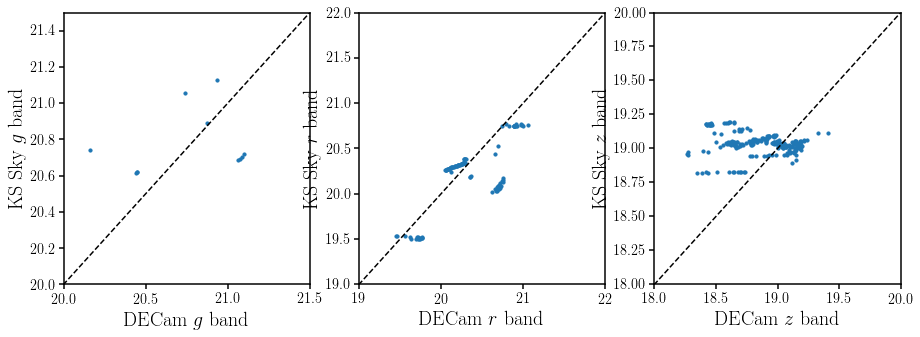

In [22]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(decam['SKYBR'][cut_g], g_ks_sky, s=10, lw=1)
sub.plot([16, 22], [16, 22], c='k', ls='--')
sub.set_xlabel('DECam $g$ band', fontsize=20)
sub.set_xlim([20, 21.5])
sub.set_ylabel('KS Sky $g$ band', fontsize=20)
sub.set_ylim([20, 21.5])

sub = fig.add_subplot(132)
sub.scatter(decam['SKYBR'][cut_r], r_ks_sky, s=10, lw=1)
sub.plot([16, 22], [16, 22], c='k', ls='--')
sub.set_xlabel('DECam $r$ band', fontsize=20)
sub.set_xlim([19, 22])
sub.set_ylabel('KS Sky $r$ band', fontsize=20)
sub.set_ylim([19, 22])

sub = fig.add_subplot(133)
sub.scatter(decam['SKYBR'][cut_z], z_ks_sky, s=10, lw=1)
sub.plot([16, 22], [16, 22], c='k', ls='--')
sub.set_xlabel('DECam $z$ band', fontsize=20)
sub.set_xlim([18, 20])
sub.set_ylabel('KS Sky $z$ band', fontsize=20)
sub.set_ylim([18, 20])

In [23]:
psky = Sky.skySpec(decam['RA'][0], decam['DEC'][0], time[0])

/Users/chang/anaconda2/lib/python2.7/site-packages/feasibgs/skymodel.py:270: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  coeffs = pd.DataFrame.from_csv(f)
/Users/chang/anaconda2/lib/python2.7/site-packages/feasibgs/skymodel.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.coeffs[k] = np.array(self.coeffs[k])[self.wave_sort]


In [24]:
decam.colnames

['DATE',
 'AIRMASS',
 'RA',
 'DEC',
 'FILTER',
 'SKYBR',
 'MOONSEP',
 'MOONPHASE',
 'MOONUP',
 'SUNALT',
 'SUNSEP',
 'TRANSP',
 'EXPTIME',
 'ZD',
 'SEEING',
 'SKYSIG',
 'DEPTH',
 'MOONFRAC',
 'MOON_RA',
 'MOON_DEC',
 'MOON_ALT',
 'MOON_AZ',
 'MOON_SEP',
 'GAL_LAT',
 'GAL_LONG',
 'ECL_LAT',
 'MONTH_FRAC']

In [25]:
def get_ParkerSky_mag(band): 
    filter_response = speclite.filters.load_filter('decam2014-{}'.format(band))
    
    if band == 'g': cut = cut_g 
    elif band == 'r': cut = cut_r
    elif band == 'z': cut = cut_z
    nrows = np.sum(cut)
    sky_brightness = np.empty(nrows, dtype=float)

    for i in range(nrows):
        Iairmass = psky.coeffs['c_am'] * decam['AIRMASS'][cut][i]
        Izodiacial = psky.coeffs['c_zodi'] * psky.I_zodi(decam['ECL_LAT'][cut][i])
        Iisl = psky.coeffs['c_isl'] * psky.I_isl(decam['GAL_LAT'][cut][i], decam['GAL_LONG'][cut][i])
        Isolar_flux = psky.coeffs['sol'] * psky.I_sf(time.mjd[cut][i] - psky.coeffs['I'])
        month_frac = time[cut][i].datetime.month + time[cut][i].datetime.day / 30.
        Iseasonal = psky.cI_seas(month_frac)
        # Ihourly = self.cI_hour(self.hour_frac)
        dT = psky.deltaT(decam['AIRMASS'][cut][i])
        Itwilight = psky.cI_twi_exp(decam['SUNALT'][cut][i], decam['SUNSEP'][cut][i], decam['AIRMASS'][cut][i])
        Imoon = psky.cI_moon_exp(decam['MOON_ALT'][cut][i], decam['MOONFRAC'][cut][i], decam['MOON_SEP'][cut][i], 
                                 decam['MOONPHASE'][cut][i] * np.pi, decam['AIRMASS'][cut][i])
        Iadd_continuum = psky.coeffs['c0']
        Isky = (Iairmass + Izodiacial + Iisl + Isolar_flux + Iseasonal + Iadd_continuum) * dT + Itwilight + Imoon
        scattered_moon = Isky/np.pi * 1e-17 * u.erg / (u.Angstrom * u.cm ** 2 * u.s)
        moon_flux, sky_wlen = filter_response.pad_spectrum(scattered_moon, 10.* psky.coeffs['wl'])
        sky_brightness[i] = filter_response.get_ab_maggies(moon_flux, sky_wlen)
    return flux_to_mag(sky_brightness)

In [69]:
g_park_sky = get_ParkerSky_mag('g')
r_park_sky = get_ParkerSky_mag('r')
z_park_sky = get_ParkerSky_mag('z')

/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


(18, 21)

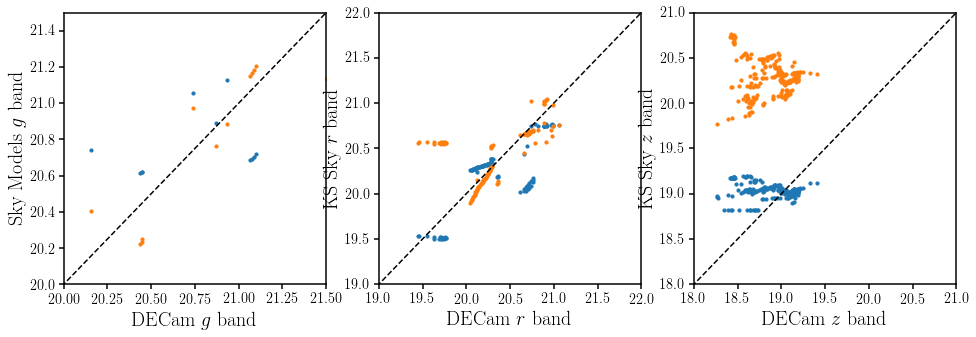

In [70]:
fig = plt.figure(figsize=(16,5))
sub = fig.add_subplot(131)
sub.scatter(decam['SKYBR'][cut_g], g_ks_sky, s=10, lw=1)
sub.scatter(decam['SKYBR'][cut_g], g_park_sky, s=10, lw=1)
sub.plot([16, 22], [16, 22], c='k', ls='--')
sub.set_xlabel('DECam $g$ band', fontsize=20)
sub.set_xlim([20, 21.5])
sub.set_ylabel('Sky Models $g$ band', fontsize=20)
sub.set_ylim([20, 21.5])

sub = fig.add_subplot(132)
sub.scatter(decam['SKYBR'][cut_r], r_ks_sky, s=10, lw=1)
sub.scatter(decam['SKYBR'][cut_r], r_park_sky, s=10, lw=1)
sub.plot([16, 22], [16, 22], c='k', ls='--')
sub.set_xlabel('DECam $r$ band', fontsize=20)
sub.set_xlim([19, 22])
sub.set_ylabel('KS Sky $r$ band', fontsize=20)
sub.set_ylim([19, 22])

sub = fig.add_subplot(133)
sub.scatter(decam['SKYBR'][cut_z], z_ks_sky, s=10, lw=1)
sub.scatter(decam['SKYBR'][cut_z], z_park_sky, s=10, lw=1)
sub.plot([16, 22], [16, 22], c='k', ls='--')
sub.set_xlabel('DECam $z$ band', fontsize=20)
sub.set_xlim([18, 21])
sub.set_ylabel('KS Sky $z$ band', fontsize=20)
sub.set_ylim([18, 21])

(0.0, 1.0)

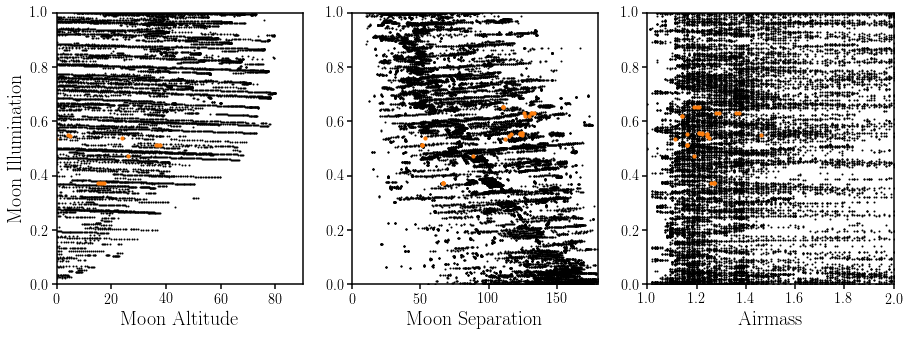

In [71]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(decam['MOON_ALT'][keep & transp], decam['MOONFRAC'][keep & transp], c='k', s=1)
sub.scatter(decam['MOON_ALT'][cut_g], decam['MOONFRAC'][cut_g], c='C1', s=10)
sub.set_xlabel('Moon Altitude', fontsize=20)
sub.set_xlim([0., 90.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0., 1.])
sub = fig.add_subplot(132)
sub.scatter(decam['MOONSEP'][keep & transp], decam['MOONFRAC'][keep & transp], c='k', s=1)
sub.scatter(decam['MOONSEP'][cut_g], decam['MOONFRAC'][cut_g], c='C1', s=10)
sub.set_xlabel('Moon Separation', fontsize=20)
sub.set_xlim([0., 180.])
sub.set_ylim([0., 1.])
sub = fig.add_subplot(133)
sub.scatter(decam['AIRMASS'][keep & transp], decam['MOONFRAC'][keep & transp], c='k', s=1)
sub.scatter(decam['AIRMASS'][cut_g], decam['MOONFRAC'][cut_g], c='C1', s=10)
sub.set_xlabel('Airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylim([0., 1.])

In [72]:
from sklearn.neighbors import NearestNeighbors

boss_meta_white = (boss_meta.T - np.average(boss_meta, axis=1))/np.std(boss_meta, axis=1)
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(boss_meta_white)

In [73]:
def get_nearestBOSSSky_mag(band): 
    filter_response = speclite.filters.load_filter('decam2014-{}'.format(band))
    
    if band == 'g': cut = cut_g 
    elif band == 'r': cut = cut_r
    elif band == 'z': cut = cut_z
    nrows = np.sum(cut)
    sky_brightness = np.empty(nrows, dtype=float)
    dists = np.empty(nrows, dtype=float)
    for i in range(nrows):
        theta_i = np.array([decam[k][cut][i] for k in ['AIRMASS', 'MOON_SEP', 'MOON_ALT', 'MOONFRAC', 'SUNSEP', 'SUNALT']])
        # find nearest neighbor 
        theta_w = (theta_i - np.average(boss_meta, axis=1))/np.std(boss_meta, axis=1)
        dist_i, i_boss = nbrs.kneighbors(theta_w.reshape(-1,1).T) 
        dists[i] = dist_i
        scattered_moon = boss_blue['SKY'][i_boss]/np.pi * 1e-17 * u.erg / (u.Angstrom * u.cm ** 2 * u.s)
        notnan = np.isfinite(boss_blue['SKY'][i_boss])
        moon_flux, sky_wlen = filter_response.pad_spectrum(scattered_moon[notnan], 10.* boss_blue['WAVE'][i_boss][notnan].flatten() * u.Angstrom)
        sky_brightness[i] = filter_response.get_ab_maggies(moon_flux, sky_wlen)
    return flux_to_mag(sky_brightness), dists

In [74]:
g_boss_sky, dist_g = get_nearestBOSSSky_mag('g')
r_boss_sky, dist_r = get_nearestBOSSSky_mag('r')
z_boss_sky, dist_z = get_nearestBOSSSky_mag('z')

(16, 22)

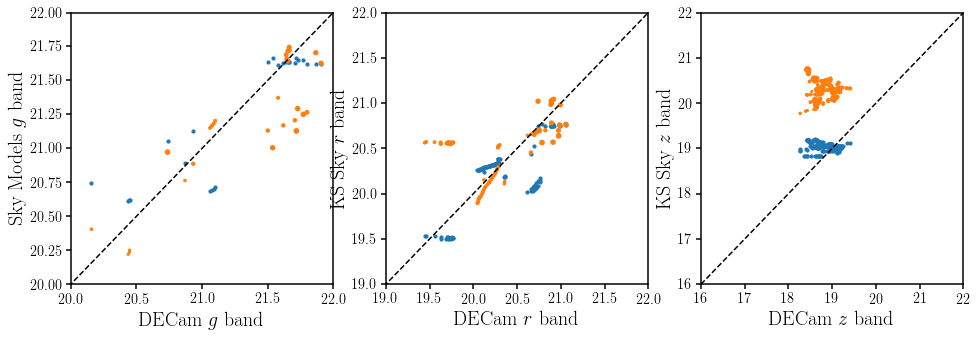

In [78]:
fig = plt.figure(figsize=(16,5))
sub = fig.add_subplot(131)
sub.scatter(decam['SKYBR'][cut_g], g_ks_sky, s=10, lw=1)
sub.scatter(decam['SKYBR'][cut_g], g_park_sky, s=10*dist_g, lw=1)
#sub.scatter(decam['SKYBR'][cut_g], g_boss_sky, s=10.*dist_g, lw=1, c='r')
sub.plot([16, 22], [16, 22], c='k', ls='--')
sub.set_xlabel('DECam $g$ band', fontsize=20)
sub.set_xlim([20., 22])
sub.set_ylabel('Sky Models $g$ band', fontsize=20)
sub.set_ylim([20., 22])

sub = fig.add_subplot(132)
sub.scatter(decam['SKYBR'][cut_r], r_ks_sky, s=10, lw=1)
sub.scatter(decam['SKYBR'][cut_r], r_park_sky, s=10*dist_r, lw=1)
#sub.scatter(decam['SKYBR'][cut_r], r_boss_sky, s=10.*dist_r, lw=1, c='r')
sub.plot([16, 22], [16, 22], c='k', ls='--')
sub.set_xlabel('DECam $r$ band', fontsize=20)
sub.set_xlim([19, 22])
sub.set_ylabel('KS Sky $r$ band', fontsize=20)
sub.set_ylim([19, 22])

sub = fig.add_subplot(133)
sub.scatter(decam['SKYBR'][cut_z], z_ks_sky, s=10, lw=1)
sub.scatter(decam['SKYBR'][cut_z], z_park_sky, s=10*dist_z, lw=1)
#sub.scatter(decam['SKYBR'][cut_r], r_boss_sky, s=10.*dist_r, lw=1, c='r')
sub.plot([16, 22], [16, 22], c='k', ls='--')
sub.set_xlabel('DECam $z$ band', fontsize=20)
sub.set_xlim([16, 22])
sub.set_ylabel('KS Sky $z$ band', fontsize=20)
sub.set_ylim([16, 22])

(-1.0, 1.0)

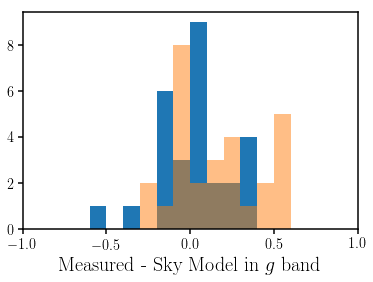

In [79]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.hist(decam['SKYBR'][cut_g] - g_ks_sky, range=(-2., 2.), bins=40, label='UVES + KS')
sub.hist(decam['SKYBR'][cut_g] - g_park_sky, range=(-2., 2.), bins=40, alpha=0.5, label='UVE')
sub.set_xlabel('Measured - Sky Model in $g$ band', fontsize=20)
sub.set_xlim([-1., 1. ])

(-1.0, 1.0)

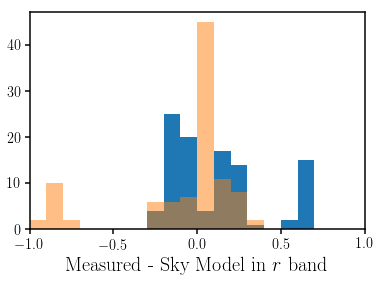

In [80]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.hist(decam['SKYBR'][cut_r] - r_ks_sky, range=(-2., 2.), bins=40)
sub.hist(decam['SKYBR'][cut_r] - r_park_sky, range=(-2., 2.), bins=40, alpha=0.5)
#sub.hist(decam['SKYBR'][cut_r] - r_boss_sky, range=(-2., 2.), bins=40, color='red', alpha=0.5)
sub.set_xlabel('Measured - Sky Model in $r$ band', fontsize=20)
sub.set_xlim([-1., 1. ])